# Introduction to Topological Data Analysis, Part II

In this notebook we will focus on methods for comparing topological signatures. We will try an application to shape matching.

In [1]:
# Import standard packages for TDA and scientific computing
from ripser import ripser
from ripser import Rips
import persim
from persim import PersImage
from persim import plot_diagrams 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn import datasets
from math import ceil
import time

# Import packages for loading .mat files
import os 
from os.path import dirname, join as pjoin
import scipy.io as sio

## Example 1: Computing Persistence Diagrams, Review

Define a point cloud.

In [2]:
N = 1000
r = 5
R = 10

theta = 2*np.pi*np.random.rand(N)
phi = 2*np.pi*np.random.rand(N)
X = (R + r * np.cos(phi)) * np.cos(theta)
Y = (R + r * np.cos(phi)) * np.sin(theta) 
Z = r *  np.sin(phi)
pointCloud = np.append(X.reshape(N,1),Y.reshape(N,1),axis =1)
pointCloud = np.append(pointCloud,Z.reshape(N,1), axis = 1)

Plot the point cloud.

NotImplementedError: It is not currently possible to manually set the aspect on 3D axes

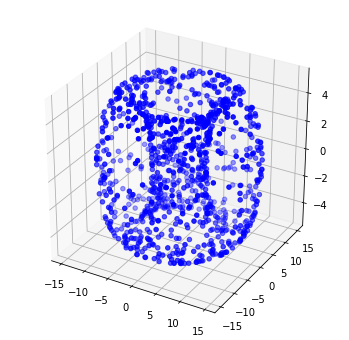

In [4]:
fig = plt.figure(figsize = (6,6))
ax = fig.gca(projection='3d', adjustable='box')
ax.scatter(pointCloud[:,0],pointCloud[:,1],pointCloud[:,2], c='b', marker='o');
# The following command doesn't seem to work here... I believe this is a known issue with matplotlib
ax.set_aspect('equal');

Using `ripser`, we compute the persistent homology of our point cloud and plot the resulting persistence diagrams. We only compute homology up to degree-1 for the sake of time.

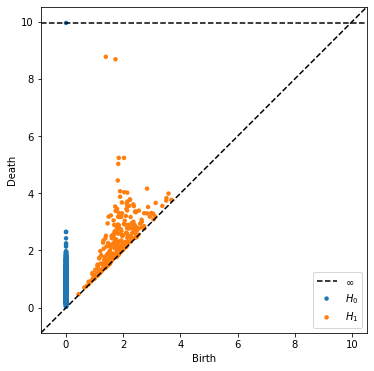

In [5]:
dgms = ripser(pointCloud)['dgms']
fig = plt.figure(figsize=(6,6))
plot_diagrams(dgms, show=True)

Does the output make sense? How does it change if we play with the parameters in the creation of our point cloud?

## Example 2: Bottleneck Distance and Shape Classification

### Loading and Exploring the Data

First we need to load the data set. The data consists of a large number of densely sampled plane curves representing various objects (bones, dogs, cars, etc.). The file is a .mat file, which we read into Python with the following commands.

In [6]:
data_dir = os.getcwd() # Get the current working directory name.
mat_fname = pjoin(data_dir, 'planarShapes.mat') 
# Add the file name to the current working directory.

mat_contents = sio.loadmat(mat_fname) # Read the file

Let's take a look at what is contained in the file.

In [7]:
mat_contents

{'__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Sat Apr 14 11:14:24 2018',
 '__version__': '1.0',
 '__globals__': [],
 'planarShapes': array([[[357.34453529, 357.44718391, 357.37970648, ...,  83.38883583,
          159.45819277,  78.49098244],
         [347.75040292, 347.25818387, 347.57146265, ...,  79.33298424,
          153.64433782,  77.51641748],
         [335.65167015, 334.66219996, 335.31828711, ...,  75.50067507,
          145.06346946,  75.98649446],
         ...,
         [382.34195746, 383.10101704, 382.58259628, ..., 105.00318471,
          177.03582561,  92.11431972],
         [368.61866608, 369.59966211, 369.02935511, ...,  93.29463409,
          169.58421811,  84.79921417],
         [358.82786411, 359.34800766, 359.06800864, ...,  85.56932952,
          162.53121921,  79.92520447]],
 
        [[  1.45686688,   1.48050543,   1.4549982 , ...,  38.82553081,
           17.85770528,  88.12826329],
         [  8.85738844,   9.36434503,   9.06410148, ...,  4

Looks like we need to separate the actual data from the metadata. The types of data in the file are listed under several "keys". 

In [8]:
mat_contents.keys()

dict_keys(['__header__', '__version__', '__globals__', 'planarShapes'])

The plane curves we are after are under the 'planarShapes' key. Let's extract that from the mat file.

In [9]:
planarShapes = mat_contents['planarShapes']
planarShapes.shape

(2, 100, 1300)

The second command above shows that planarShapes is a 2x100x1300 array. Exploring more, we would find that there are 1300 separate shapes, separated into 20 copies of similar shapes (so 65 classes of similar shapes). Each of the 1300 shapes is a pointcloud in $\mathbb{R}^2$ consisting of 100 points. Let's plot a couple of the shapes below.

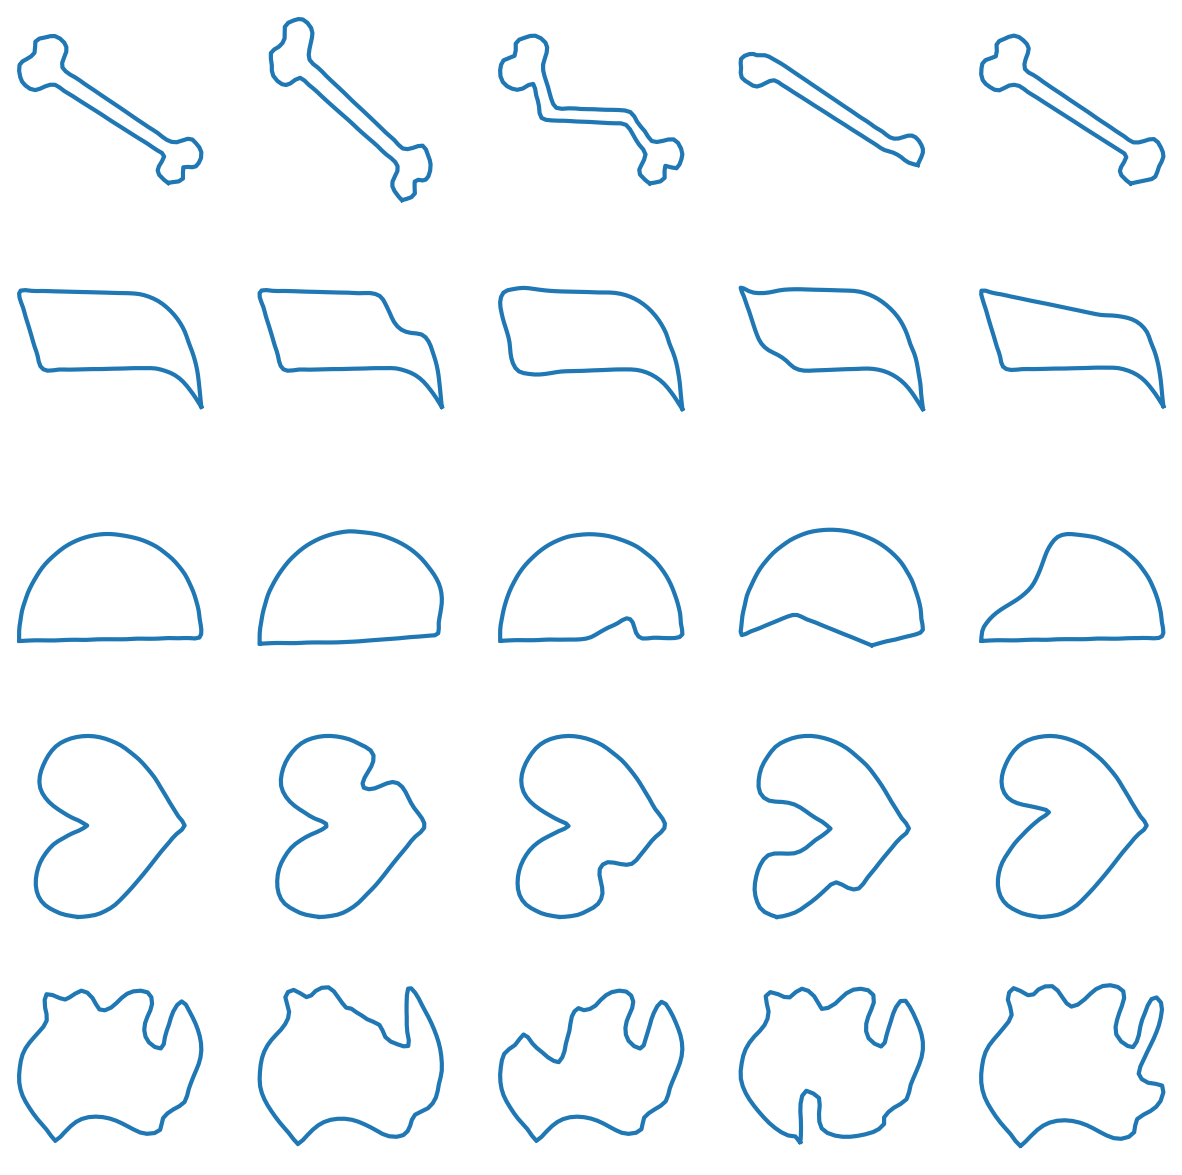

In [10]:
shape_indices = [4*x for x in range(25)]

fig = plt.figure(figsize = (15,15))

for j in range(25):
    ax = fig.add_subplot(5,5,j+1)
    shape = planarShapes[:,:,shape_indices[j]]
    ax.plot(shape[0,:], shape[1,:], linewidth=3)
    ax.axis('off')
    ax.axis('equal')

The above code plots the shapes as continuous curves, but the data for each shape is really a point cloud.

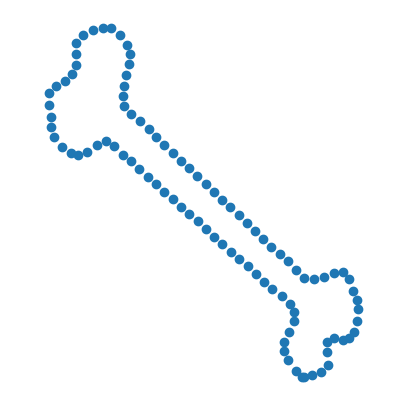

In [11]:
plt.figure(figsize=(5,5))
shape = planarShapes[:,:,4]
plt.scatter(shape[0,:], shape[1,:])
plt.axis('off')
plt.axis('equal');

### Initial Experiments with Bottleneck Distance

Let's fix some shapes to use for examples.

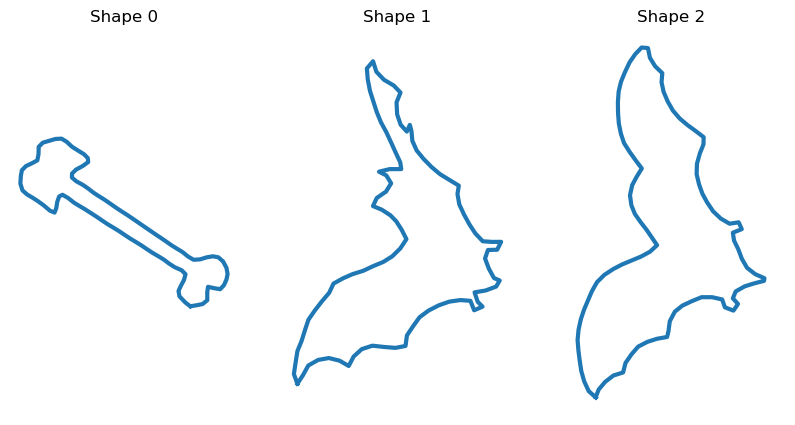

In [12]:
shape_indices = [1,125,127] # Pick some shapes.

num_shapes = len(shape_indices) 
# If you want to pick different shape indices it will be useful to save this as variable.

fig = plt.figure(figsize = (10,5))

for j in range(num_shapes):
    ax = fig.add_subplot(1,3,j+1)
    shape = planarShapes[:,:,shape_indices[j]]
    ax.plot(shape[0,:], shape[1,:], linewidth=3)
    ax.axis('off')
    plt.title('Shape '+str(j))
    ax.axis('equal')

Let's compute persistence diagrams for these examples, then look at bottleneck distances between them. Note that ripser prefers the pointclouds to be transposed. I.e., shape1 is given as a 2x100 array, but ripser wants to see a 100x2 array.

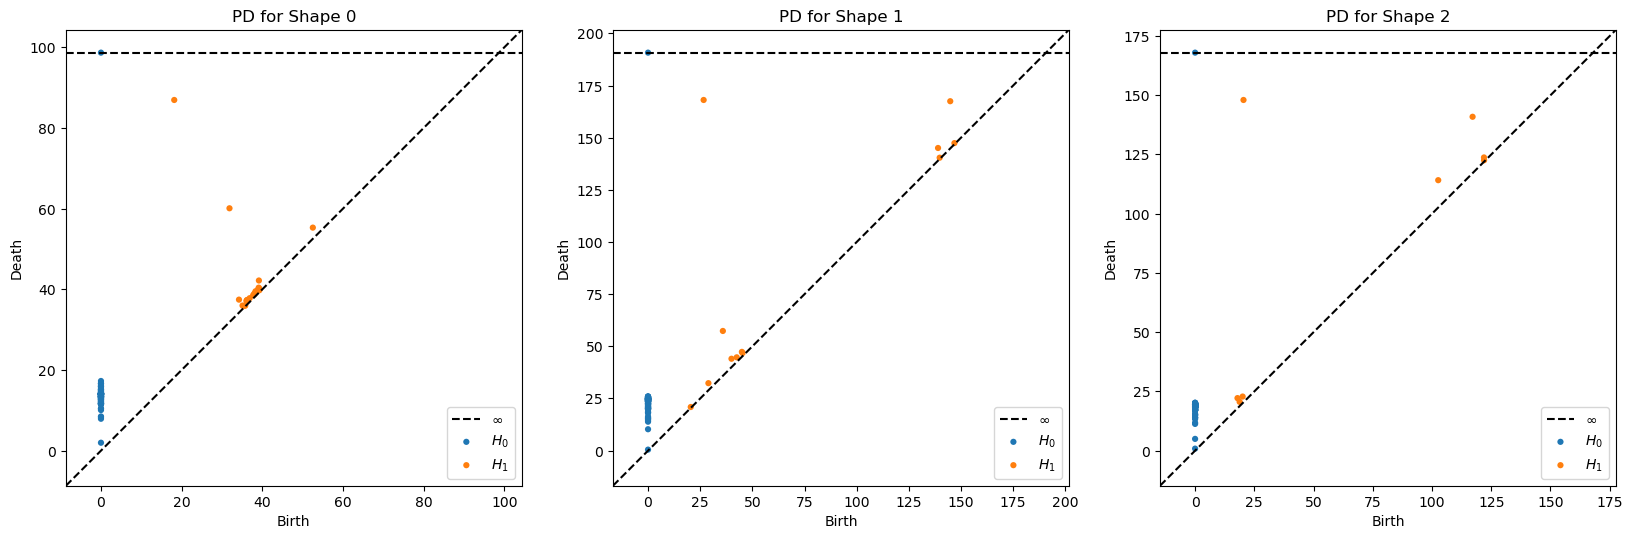

In [13]:
shapeDgms = [ripser(planarShapes[:,:,shape_indices[j]].T)['dgms'] for j in range(num_shapes)]

fig = plt.figure(figsize=(20,10))

for j in range(num_shapes):
    ax = fig.add_subplot(1,num_shapes,j+1) # You might need to change this layout if you change shape_indices
    plt.title('PD for Shape '+str(j))
    plot_diagrams(shapeDgms[j])

The "persim" package includes several distance metrics between persistence diagrams, including the bottleneck distance that we have defined in class. Let's compute bottleneck distances between our shape examples. There is an option to not only compute the distance, but to record the optimal matching which produces it. In the first example, we compute the bottleneck distance between the degree-1 persistence diagrams for shapes with indices 0 and 1.

In [14]:
distance_bottleneck, (matching, D) = persim.bottleneck(shapeDgms[0][1], shapeDgms[1][1], matching=True)
print(distance_bottleneck)

70.71136951446533


We can then plot the persistence diagrams on the same axes and display the optimal matching. The green line segment indicates matched points incurring the highest cost.

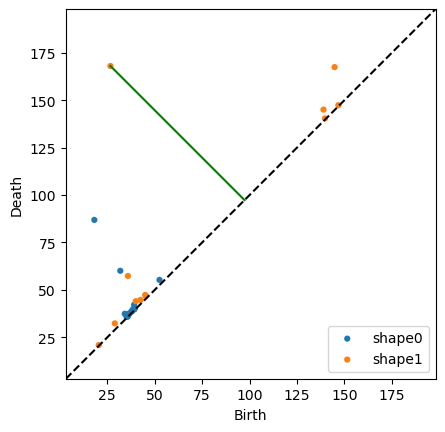

In [15]:
persim.plot.bottleneck_matching(shapeDgms[0][1], shapeDgms[1][1], matching, D, labels=['shape0', 'shape1'])

Let's also compute the distance between shapes with indices 0 and 2.

In [16]:
distance_bottleneck, (matching, D) = persim.bottleneck(shapeDgms[0][1], shapeDgms[2][1], matching=True)
print(distance_bottleneck)

61.09130859375


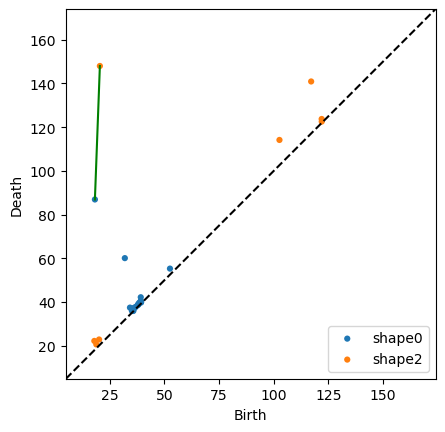

In [17]:
persim.plot.bottleneck_matching(shapeDgms[0][1], shapeDgms[2][1], matching, D, labels=['shape0', 'shape2'])

Finally, we compute the distance between shapes 1 and 2.

20.066848754882812


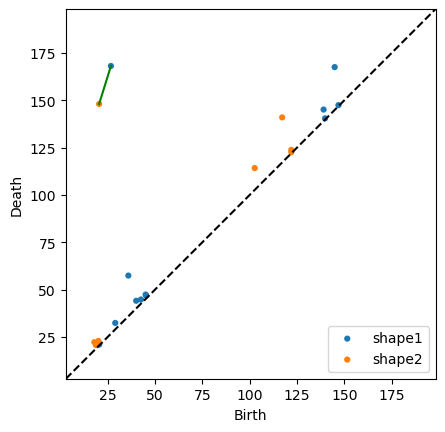

In [18]:
distance_bottleneck, (matching, D) = persim.bottleneck(shapeDgms[1][1], shapeDgms[2][1], matching=True)
print(distance_bottleneck)

persim.plot.bottleneck_matching(shapeDgms[1][1], shapeDgms[2][1], matching, D, labels=['shape1', 'shape2'])

So bottleneck distance seems to pick up on differences in the shapes. We can summarize the distances by computing a *distance matrix*. Since we are comparing 3 shapes, the distance matrix will be a $3 \times 3$ matrix whose $(i,j)$-entry is the bottleneck distance between Shape $i$ and Shape $j$.

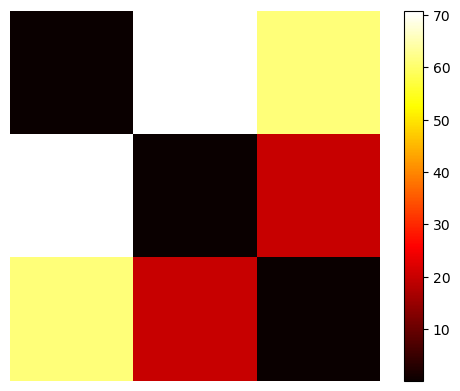

In [19]:
# Compute the distance matrix
distMat = np.zeros((3,3))

for i in range(3):
    for j in range(3):
        distMat[i,j] = persim.bottleneck(shapeDgms[i][1], shapeDgms[j][1], matching=True)[0]
        
# Display the distance matrix
img = plt.imshow(distMat)
img.set_cmap('hot')
plt.colorbar()
plt.axis('off');

### Classification Experiment

Let's now try a more serious supervised learning experiment. We'll pick several shape classes, then several examples of shapes from each class. The goal is to see whether bottleneck distance between persistence diagrams will work as a classifier for the shapes.

In [ ]:
shape_classes = [100,200,300,400,500,600,700,800] # Pick indices of shape classes to sample.
num_classes = len(shape_classes)
num_shapes = 16
# Pick number of examples to take from each shape class
# Pick carefully so that we get shapes from the same class!
# Remember the shapes come in groups of 20

# Create labels for the data
labels = []

for j in range(num_classes):
    labels = labels + num_shapes*[j]

# List all indices of the shape samples for the experiment.
samples =[]
for j in range(num_classes):
    samples = samples+range(shape_classes[j],shape_classes[j]+num_shapes)

# We now pick out the shapes with indices in 'samples' and preprocess.
num_samp = len(samples)

shapeSamples = [planarShapes[:,:,samples[j]].T for j in range(num_samp)]

Let's take a look at shapes from each of the shape classes.

In [ ]:
fig = plt.figure(figsize=(15,5))

for j in range(num_classes):
    shape_example = shapeSamples[j*num_shapes]
    ax = fig.add_subplot(1,num_classes,j+1)
    ax.plot(shape_example[:,0], shape_example[:,1], linewidth = 3)
    plt.title('Shape Class '+str(j))
    ax.axis('off')
    ax.axis('equal')
    

Let's also look at the samples within a given class of shapes.

In [ ]:
fig = plt.figure(figsize=(10,2))

for j in range(num_shapes):
    shape_example = shapeSamples[j]
    ax = fig.add_subplot(2,int(ceil(num_shapes)/2),j+1)
    ax.plot(shape_example[:,0], shape_example[:,1], linewidth = 3)
    ax.axis('off')
    ax.axis('equal')

Next we compute persistence diagrams for each of the shapes in our sampled collection. We are using the standard options for ripser, which will compute degree-0 and degree-1 persistence diagrams.

In [ ]:
shapeSamplesDgms = [ripser(shapeSamples[j])['dgms'] for j in range(num_samp)]

We can now compute bottleneck distances between all pairs of persistence diagrams. We computed persistence diagrams for degree-0 and degree-1 persistent homology in the previous cell, so we could compute bottleneck distances in each degree.

It takes quite a while to run the degree-0 computation. It is commented out in the cell below because I don't want to run it in class. Feel free to uncomment and try it yourself.

In the cell below that, we compute the distance matrix for the degree-1 persistence diagrams. Note that, if there are N total shape samples, then this distance matrix should be an NxN symmetric matrix. The $(i,j)$-entry is the bottleneck distance between the persistence diagram of shape $i$ and shape $j$. We are really thinking of each shape as a point in a metric space!

In [ ]:
# Uncomment this cell and run it if you want to!

#distMatDeg0 = np.zeros([num_samp,num_samp])

#for j in range(num_samp):
#    for k in range(j+1,num_samp):
#        distMatDeg0[j,k] = persim.bottleneck(shapeSamplesDgms[j][0], shapeSamplesDgms[k][0])
#    print(j)

#distMatDeg0 = distMatDeg0 + np.transpose(distMatDeg0)

In [ ]:
distMatDeg1 = np.zeros([num_samp,num_samp])

for j in range(num_samp):
    for k in range(j+1,num_samp):
        distMatDeg1[j,k] = persim.bottleneck(shapeSamplesDgms[j][1], shapeSamplesDgms[k][1])

distMatDeg1 = distMatDeg1 + np.transpose(distMatDeg1)

To understand the structure of our metric space, we can take a look at the distance matrix.

In [ ]:
plt.figure(figsize=(5,5))
plt.imshow(distMatDeg1)
plt.colorbar();

We can use *multidimensional scaling (MDS)* to get a feel for why each metric does a good/bad job. MDS attempts to embed the metric space defined by each distance matrix into $\mathbb{R}^2$ or $\mathbb{R}^3$ (this is chosen by the user), in order to visualize clustering behavior.

In [ ]:
# Import a package containing the MDS algorithm and set options for the algorithm
from sklearn import manifold
mds = manifold.MDS(n_components=2, dissimilarity="precomputed", random_state=6)

# Compute MDS and extract the coordinates of the points
results = mds.fit(distMatDeg1)
coords = results.embedding_

plt.scatter(coords[:,0],coords[:,1], c=labels, cmap = 'hot')

The points above are colored by the class they belong to. We see that shapes of the same class are (roughly) clustered close together. This qualitatively tells us that bottleneck distance is doing a good job of distinguishing the shapes!

If you would like to see how to make this more precise, go on to the following optional section.

### Classification Scores (Optional)

This section will use some ideas from the field of machine learning. Things are mostly explained in the text, but please feel free to flag me down if you have any questions!

Our goal is to test whether bottleneck distance works as a good classifier. To get a sense of what "good" means, we would like to compare to other standard classification techniques. Most standard algorithms take vectors as input, so let's reshape our data to put it in vector form.

In [ ]:
X = [shapeSamples[j].reshape(200,) for j in range(num_samp)]
y = labels

One thing we can compare to is *Procrustes distance*. This will take a pair of shapes, try to rotate and translate one of them so that they align as much as possible, then take sum of squared distances between aligned points. I want to use Procrustes distance as a callable function later, so I will define it now.

In [ ]:
from scipy.spatial import procrustes

def procDist(X,Y):
    X1 = X.reshape(100,2)
    Y1 = Y.reshape(100,2)
    m1, m2, disp = procrustes(shapeSamples[j], shapeSamples[k])
    return disp

We can then compute the Procrustes distance matrix for our shape data, as we did above for bottleneck distance.

In [ ]:
distMatProcrustes = np.zeros([num_samp,num_samp])

for j in range(num_samp):
    for k in range(j+1,num_samp):
        distMatProcrustes[j,k] = procDist(X[j],X[k])

distMatProcrustes = distMatProcrustes + np.transpose(distMatProcrustes)

plt.figure(figsize=(5,5))
plt.imshow(distMatProcrustes)
plt.colorbar();

We will also use a callable function for bottleneck distance, so I will define one now.

In [ ]:
def bottleneckDist(X,Y):
    X1 = X.reshape(100,2)
    Y1 = Y.reshape(100,2)
    dgm1 = ripser(X1)['dgms'][1]
    dgm2 = ripser(Y1)['dgms'][1]
    return persim.bottleneck(dgm1, dgm2)   

To test classification rate, we split our data into a training set and a testing set. This means we pick off 80% of the shapes from the whole collection to 'train' our classification model. We will then test the performance of our classification model on the 'test' set.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1)

Now we use $k$-Nearest Neighbors classification. This model is very simple: to classify a point in the test set, we find its $k$ closest (with respect to whichever metric we are using) neighbors in the training set. Those neighbors have labels, and the majority label is assigned to the test point.

We will test the classification performance of bottleneck distance and of procrustes distance. Notice that the `scikit-learn` implementation of $k$-NN allows us to use callable functions for our distance metric. This is why I defined these earlier.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Define the bottleneck distance model and fit
neighBottleneck = KNeighborsClassifier(n_neighbors=3, algorithm='ball_tree', metric = bottleneckDist)
neighBottleneck.fit(X_train, y_train) 

# Define the Procrustes distance model and fit
neighProc = KNeighborsClassifier(n_neighbors=3, algorithm='ball_tree', metric = procDist)
neighProc.fit(X_train, y_train) 

Now we find the classification rate for each metric on the testing set. This takes a while, by the nature of $k$NN, the fact that we are using callable functions as our metrics, and the slowness of the bottleneck distance computation.

In [ ]:
neighBottleneck.score(X_test,y_test)

In [ ]:
neighProc.score(X_test,y_test)

We see that bottleneck distance performs relatively well! This is made more apparent by the quite poor performance of Procrustes distance, which most would consider to be the "standard" metric to use here.

Let's look at the MDS plot of the Procrustes distance matrix to see what is going wrong.

In [ ]:
results = mds.fit(distMatProcrustes)
coords = results.embedding_

plt.scatter(coords[:,0],coords[:,1], c=labels, cmap = 'hot')

To see what was predicted correctly/incorrectly, we can look at the *confusion matrix*. For a general multiclass classification problem with labels $0,1,\ldots,K$, the confusion matrix is the $(K+1) \times (K+1)$ matrix
$$
C = (C_{ij}) = \left(\begin{array}{cccc}
C_{00} & C_{01} & \cdots & C_{0K} \\
C_{10} & C_{11} & \cdots & C_{1K} \\
\vdots & \vdots & & \vdots \\
C_{K0} & C_{K1} & \cdots & C_{KK} \end{array}\right)
$$
with entry $C_{ij}$ giving the number of observations known to be in group $i$ and predicted to be in group $j$.

This can be computed via `scikit-learn` as follows.

In [ ]:
from sklearn import metrics
predictedBottleneck = neighBottleneck.predict(X_test)
print(metrics.confusion_matrix(y_test, predictedBottleneck))

In [ ]:
predictedProc = neighProc.predict(X_test)
print(metrics.confusion_matrix(y_test, predictedProc))

Apparently Procrustes distance was extrememly confused by Shape 2!

### Exercise

If you are familiar with Machine Learning techniques, see if you can create a model which outperforms TDA on this dataset. This is *certainly* possible, but I think it requires some cleverness. I.e., I don't believe that applying basic `scikit-learn` algorithms directly will do the trick.